In [3]:
from shapely.geometry import Point, Polygon
from StateEstimator import ParticleFilter
from World import World
import matplotlib.pyplot as plt
import numpy as np
from IPython import display
import time

In [5]:
# Define the shape, location, and angle of the object.
shape = Polygon([[0, 0], [1, 0], [1, 1], [0, 1], [0, 0]])
x = 4
y = 1
theta = np.pi/4

# Create a World object to store the map and do measurements.
map_size = (5,5) 
w = World(shape, x, y, theta, map_size)

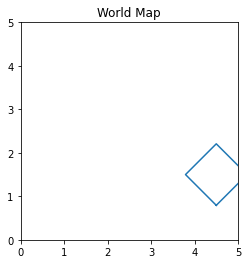

In [6]:
fig, ax = plt.subplots()
w.plot(ax)

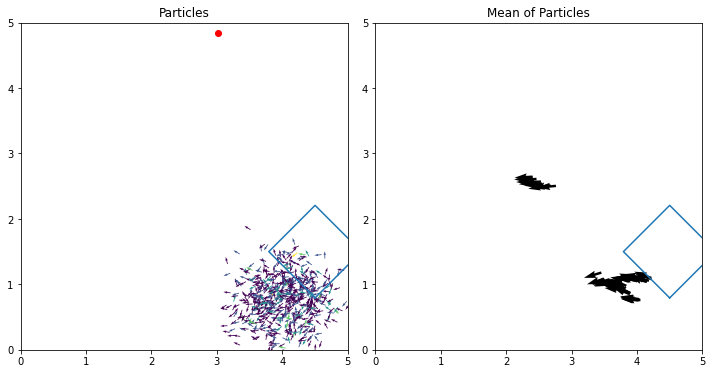

In [7]:
# Make a particle  filter
n = 50 # run for n steps.
pf = ParticleFilter(shape, 1000, map_size)

# Set up two plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 10))
w.plot(ax1)
w.plot(ax2)
ax1.set_title('Particles')
ax2.set_title('Mean of Particles')
fig.tight_layout()

# Iterate through the particle filter, measuring randomly.
for i in range(n):
    # select random measurement
    x = np.random.uniform(0,map_size[0])
    y = np.random.uniform(0,map_size[1])
    
    # update particle filter with measurement
    z = w.measure(x, y)
    pf.update(z)
    
    # Plot
    s = ax1.scatter(z[0], z[1], c='r')
    q = pf.draw_particles(ax1)
    
    x,y,t = pf.get_state() # access estimated state
    
    q2 = ax2.quiver(x, y, np.cos(t), np.sin(t), label='Estimate')
    display.display(fig)
    display.clear_output(wait=True)
    time.sleep(0.01)
    
    if i != n-1:
        q.remove()
        s.remove()